# Homework#9 - Dragana Pahovec

### Note: model is trained on 20% of train data(50:50 - cats:dogs) in order to be tested on JupyterLab

In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import random
from collections import Counter, defaultdict
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.utils import np_utils
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

from sklearn.model_selection import train_test_split

In [2]:

def readDataset(files: list):
  images = []
  labels = []
  max_x, max_y = 0, 0
  min_x, min_y = 10000, 10000
  for file in files:
    try:
        image = cv2.imread(file,1).astype(np.float32)
        max_x = max(max_x, image.shape[0])
        min_x = min(min_x, image.shape[0])
        max_y = max(max_y, image.shape[0])
        min_y = min(min_y, image.shape[0])
        # preprcessing
        image = cv2.resize(image, (90, 70)) # width, height
        image/=255.0 # scales the images
        images.append(image)
        labels.append(''.join([el for el in os.path.basename(file).split('.')[0] if not el.isdigit()]))
    except Exception as e:
        print(e)
        print("Bad format:",file)
        continue

  print('x range:',min_x, max_x)
  print('y range:',min_y, max_y)

  dataset = np.zeros((len(images), 70, 90, 3)) # no. instances, height, width, channels
  for i, im in enumerate(images):
        dataset[i] = images[i]
  return dataset, labels


### Train data

In [3]:
train_file = glob.glob("train/*.*")
dataset_train, labels = readDataset(train_file)
assert dataset_train.shape[0] == len(labels)
print(dataset_train.shape)
print(len(labels))

x range: 41 768
y range: 41 768
(5000, 70, 90, 3)
5000


In [4]:
Counter(labels)

Counter({'cat': 2500, 'dog': 2500})

In [5]:
# encoding the labels
cat_to_lab = dict(enumerate(set(labels)))
lab_to_cat = {v:k for k, v in cat_to_lab.items()}

print(cat_to_lab)
print(lab_to_cat)
targets = [lab_to_cat[el] for el in labels]

{0: 'cat', 1: 'dog'}
{'cat': 0, 'dog': 1}


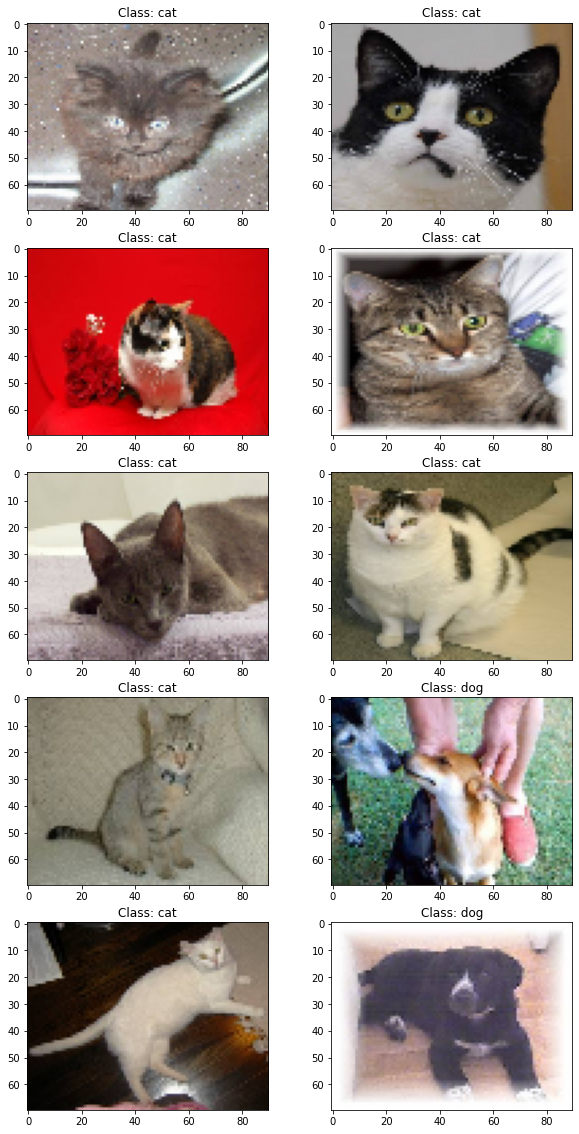

In [6]:
# Visualizing the first 10 images from the train dataset:
fig = plt.figure(figsize=(10,20))
nrows = 5
ncols = 2
for i in range(nrows*ncols): 
    idx = random.randint(0, dataset_train.shape[0]-1)
    subfigure = fig.add_subplot(nrows, ncols, (i+1))  
    subfigure.imshow(dataset_train[idx][:,:,::-1]) ## have to reverse RGB to BGR because of matplotlib
    
    title = ("Class: "+ labels[idx])
    plt.title(title)
plt.show()

## Test data

In [7]:
test_file = glob.glob("test1/*.*")
dataset_test, labels = readDataset(test_file)
assert dataset_test.shape[0] == len(labels)
print(dataset_test.shape)
print(len(labels))

x range: 50 500
y range: 50 500
(1250, 70, 90, 3)
1250


In [8]:
test_file.pop(1)

'test1\\10.jpg'

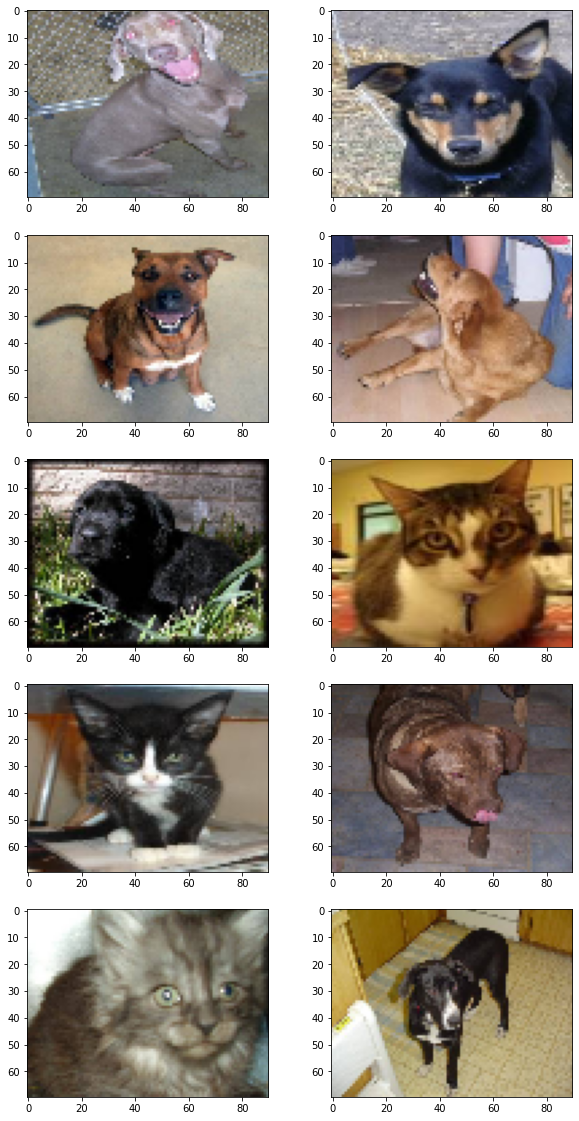

In [9]:
# Visualizing the first 10 images from the test dataset:
fig = plt.figure(figsize=(10,20))
nrows = 5
ncols = 2
for i in range(nrows*ncols): 
    idx = random.randint(0, dataset_test.shape[0]-1)
    subfigure = fig.add_subplot(nrows, ncols, (i+1))  
    subfigure.imshow(dataset_test[idx][:,:,::-1]) ## have to reverse RGB to BGR because of matplotlib
plt.show()

# Splitting the data

In [10]:

#targets_oh = np_utils.to_categorical(targets, len(set(targets)))
X_train, X_test, Y_train, Y_test = train_test_split(dataset_train, targets, test_size=0.3, random_state=SEED, stratify=targets)
assert X_train.shape[0] == len(Y_train)
assert X_test.shape[0] == len(Y_test)
print('Targets:', Counter(targets))
print('Y_train:',Counter(Y_train))
print('Y_test:',Counter(Y_test))

Targets: Counter({0: 2500, 1: 2500})
Y_train: Counter({1: 1750, 0: 1750})
Y_test: Counter({0: 750, 1: 750})


In [11]:
X_train.shape

(3500, 70, 90, 3)

In [12]:
X_test.shape

(1500, 70, 90, 3)

## CNN architecture

In [13]:

model = Sequential()

print(X_train.shape[1:])
model.add(Input(X_train.shape[1:])) # we skip the number of instances
model.add(Conv2D(filters=16, kernel_size=(6,6), strides=(2,2), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(6,6), strides=(2,2), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(6,6), strides=(2,2), activation='relu'))
model.add(BatchNormalization())

# model.add(Conv2D(filters=128, kernel_size=(6,6), strides=(2,2), activation='relu'))
# model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))

model.summary()

(70, 90, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 43, 16)        1744      
                                                                 
 batch_normalization (BatchN  (None, 33, 43, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 19, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 19, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 7, 64)          73792     
                                                                 
 batch_normalization_2 (Batc  (None, 5, 7, 6

In [14]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [15]:
Counter(Y_train)

Counter({1: 1750, 0: 1750})

In [16]:
print('X_train shape:', X_train.shape)
print('X_train type:', type(X_train))
print('Y_train type:', type(Y_train))

X_train shape: (3500, 70, 90, 3)
X_train type: <class 'numpy.ndarray'>
Y_train type: <class 'list'>


In [17]:
Y = np.array(Y_train)

In [18]:
Y.shape

(3500,)

In [19]:
Y2 = np.array(Y_test)

In [20]:
Y2.shape

(1500,)

# Training the model

In [21]:
history = model.fit(X_train, Y, batch_size=64, epochs=20, validation_data=(X_test, Y2), shuffle=True)

Epoch 1/20
55/55 [==============================] - 7s 110ms/step - loss: 0.0000e+00 - accuracy: 0.5594 - val_loss: 0.0000e+00 - val_accuracy: 0.5487
Epoch 2/20
55/55 [==============================] - 6s 103ms/step - loss: 0.0000e+00 - accuracy: 0.6040 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 3/20
55/55 [==============================] - 5s 96ms/step - loss: 0.0000e+00 - accuracy: 0.6043 - val_loss: 0.0000e+00 - val_accuracy: 0.5287
Epoch 4/20
55/55 [==============================] - 5s 96ms/step - loss: 0.0000e+00 - accuracy: 0.6263 - val_loss: 0.0000e+00 - val_accuracy: 0.5420
Epoch 5/20
55/55 [==============================] - 6s 103ms/step - loss: 0.0000e+00 - accuracy: 0.6311 - val_loss: 0.0000e+00 - val_accuracy: 0.5853
Epoch 6/20
55/55 [==============================] - 5s 97ms/step - loss: 0.0000e+00 - accuracy: 0.6409 - val_loss: 0.0000e+00 - val_accuracy: 0.6413
Epoch 7/20
55/55 [==============================] - 5s 100ms/step - loss: 0.0000e+00 - accuracy: 0.6406

47/47 - 1s - loss: 0.0000e+00 - accuracy: 0.7293 - 556ms/epoch - 12ms/step


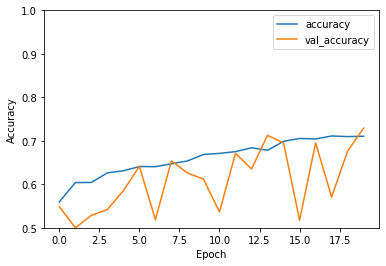

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(X_test,  Y2, verbose=2)

In [23]:
print(test_acc)

0.7293333411216736


# Predictions

In [24]:
predictions = model.predict(X_test)

47/47 [==============================] - 1s 11ms/step


Prediction legend: {'cat': 0, 'dog': 1}
-------------------------
47/47 [==============================] - 1s 10ms/step
Index number 50 prediction: [0.]


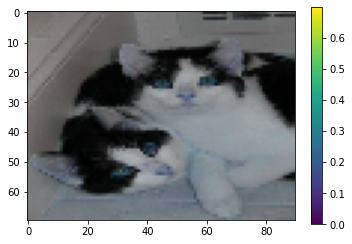

In [25]:
idx = 50
print('Prediction legend:', lab_to_cat)
print('-------------------------')
print(f'Index number {idx} prediction: {np.round(model.predict(X_test))[idx]}')

plot_idx = idx
plt.figure()
plt.imshow(dataset_test[plot_idx])
plt.colorbar()
plt.grid(False)
plt.show()

47/47 [==============================] - 0s 10ms/step
Index number 80 prediction: [0.]


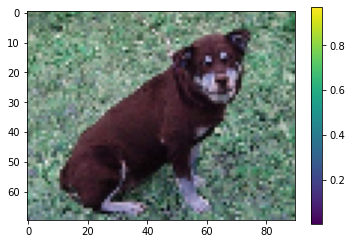

47/47 [==============================] - 0s 10ms/step
Index number 81 prediction: [1.]


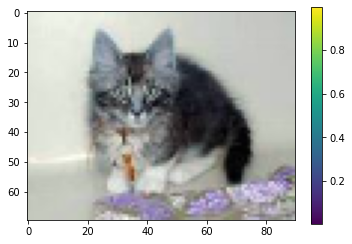

47/47 [==============================] - 1s 10ms/step
Index number 82 prediction: [1.]


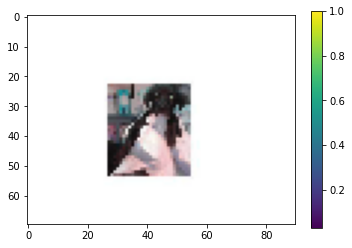

47/47 [==============================] - 1s 10ms/step
Index number 83 prediction: [0.]


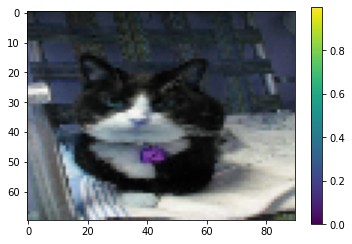

47/47 [==============================] - 1s 11ms/step
Index number 84 prediction: [1.]


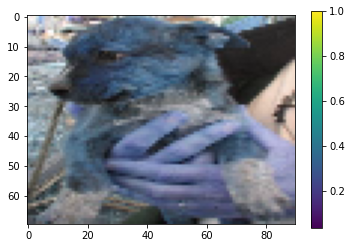

47/47 [==============================] - 1s 11ms/step
Index number 85 prediction: [0.]


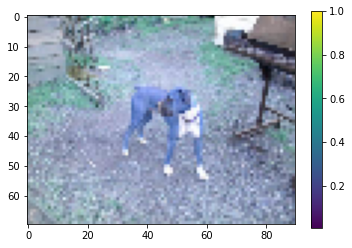

47/47 [==============================] - 1s 12ms/step
Index number 86 prediction: [0.]


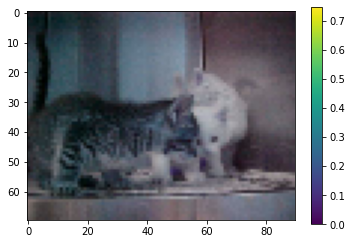

47/47 [==============================] - 1s 12ms/step
Index number 87 prediction: [0.]


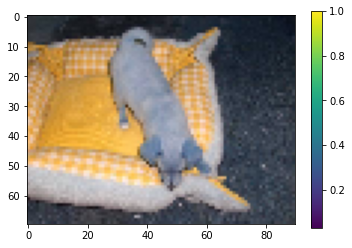

47/47 [==============================] - 1s 12ms/step
Index number 88 prediction: [0.]


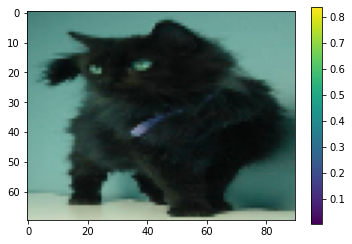

47/47 [==============================] - 1s 12ms/step
Index number 89 prediction: [1.]


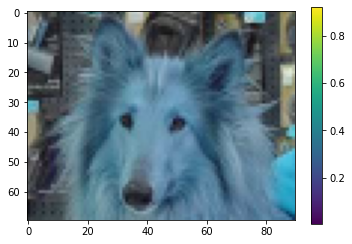

In [26]:
for idx in range (80,90):
    print(f'Index number {idx} prediction: {np.round(model.predict(X_test))[idx]}')
    plot_idx = idx
    plt.figure()
    plt.imshow(dataset_test[plot_idx])
    plt.colorbar()
    plt.grid(False)
    plt.show()
    